In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import spacy  # Pour la lemmatisation


In [2]:
import pandas as pd

# Load the CSV file
df_train_csv = pd.read_csv("questions_dataset.csv", header=None, names=["data"])

# Prepare an empty list to store transformed rows
transformed_data = []

# Iterate through each row
for _, row in df_train_csv.iterrows():
    # Split category into Category and Subcategory
    category_parts = row['data'].split(":")
    classe=category_parts[0]
    question_split=category_parts[1]
    # Split Question into Label and the rest
    label_question= question_split.split(' ')
    label = label_question[0]  
    question_rest =  " ".join(label_question[1:])  # The rest as the question  # Remaining part of the question
    
    # Append the transformed data as a tuple
    transformed_data.append(( question_rest,classe, label))

# Create a new DataFrame with the transformed data
df_train = pd.DataFrame(transformed_data, columns=["Question","Category", "Subcategory"])

# Save the transformed DataFrame to a new CSV file
df_train.to_csv("csv_data_file_for_test3.csv", index=False)

In [3]:
import pandas as pd

# Open the text file and read line by line
with open("test_dataset.txt", "r") as file:
    lines = file.readlines()

# Prepare an empty list to store transformed rows
transformed_data = []

# Iterate through each line in the file
for line in lines:
    line = line.strip()  # Remove any extra spaces or newlines at the beginning and end
    
    # Split the line into category and question based on the first ':'
    if ":" in line:
        category_parts = line.split(":", 1)  # Split into category and the rest of the question
        classe = category_parts[0].strip()  # The category part
        question = category_parts[1].strip()  # The rest as the question
        
        # Split the question into label and the rest of the question
        label_question = question.split(' ', 1)
        label = label_question[0].strip() if len(label_question) > 0 else ""
        question_rest = label_question[1].strip() if len(label_question) > 1 else ""
        
        # Append the transformed data as a tuple
        transformed_data.append((question_rest, classe, label))

# Create a new DataFrame with the transformed data
df_test = pd.DataFrame(transformed_data, columns=["Question", "Category", "Subcategory"])

# Save the transformed DataFrame to a new CSV file (still can save as CSV even if original was TXT)
df_test.to_csv("test_txt_for_test3.csv", index=False)


In [4]:
df_train.size

16356

In [5]:
df_test.size

1500

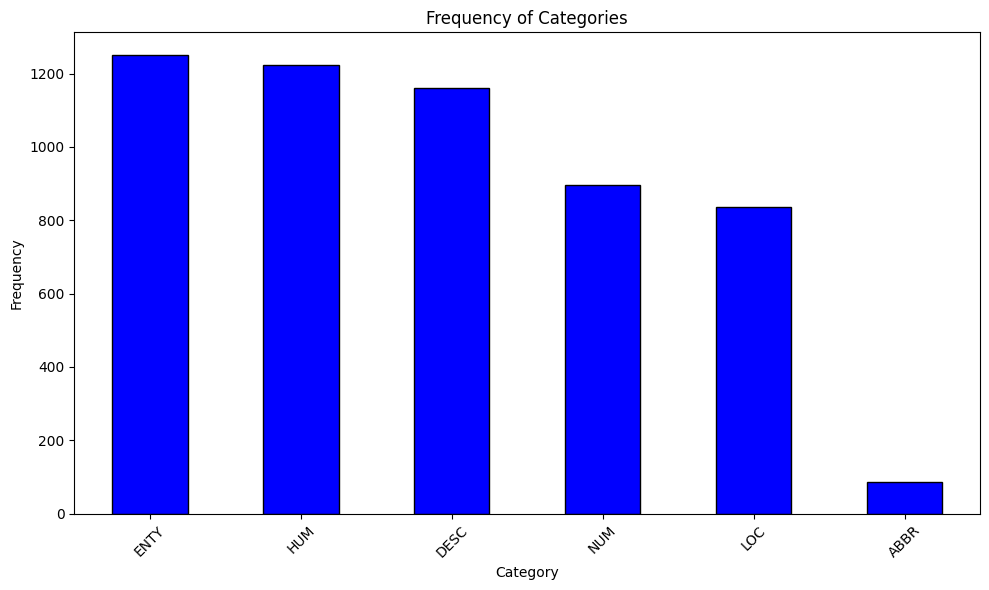

In [6]:
import matplotlib.pyplot as plt


category_frequency = df_train['Category'].value_counts()

plt.figure(figsize=(10, 6))
category_frequency.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Frequency of Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


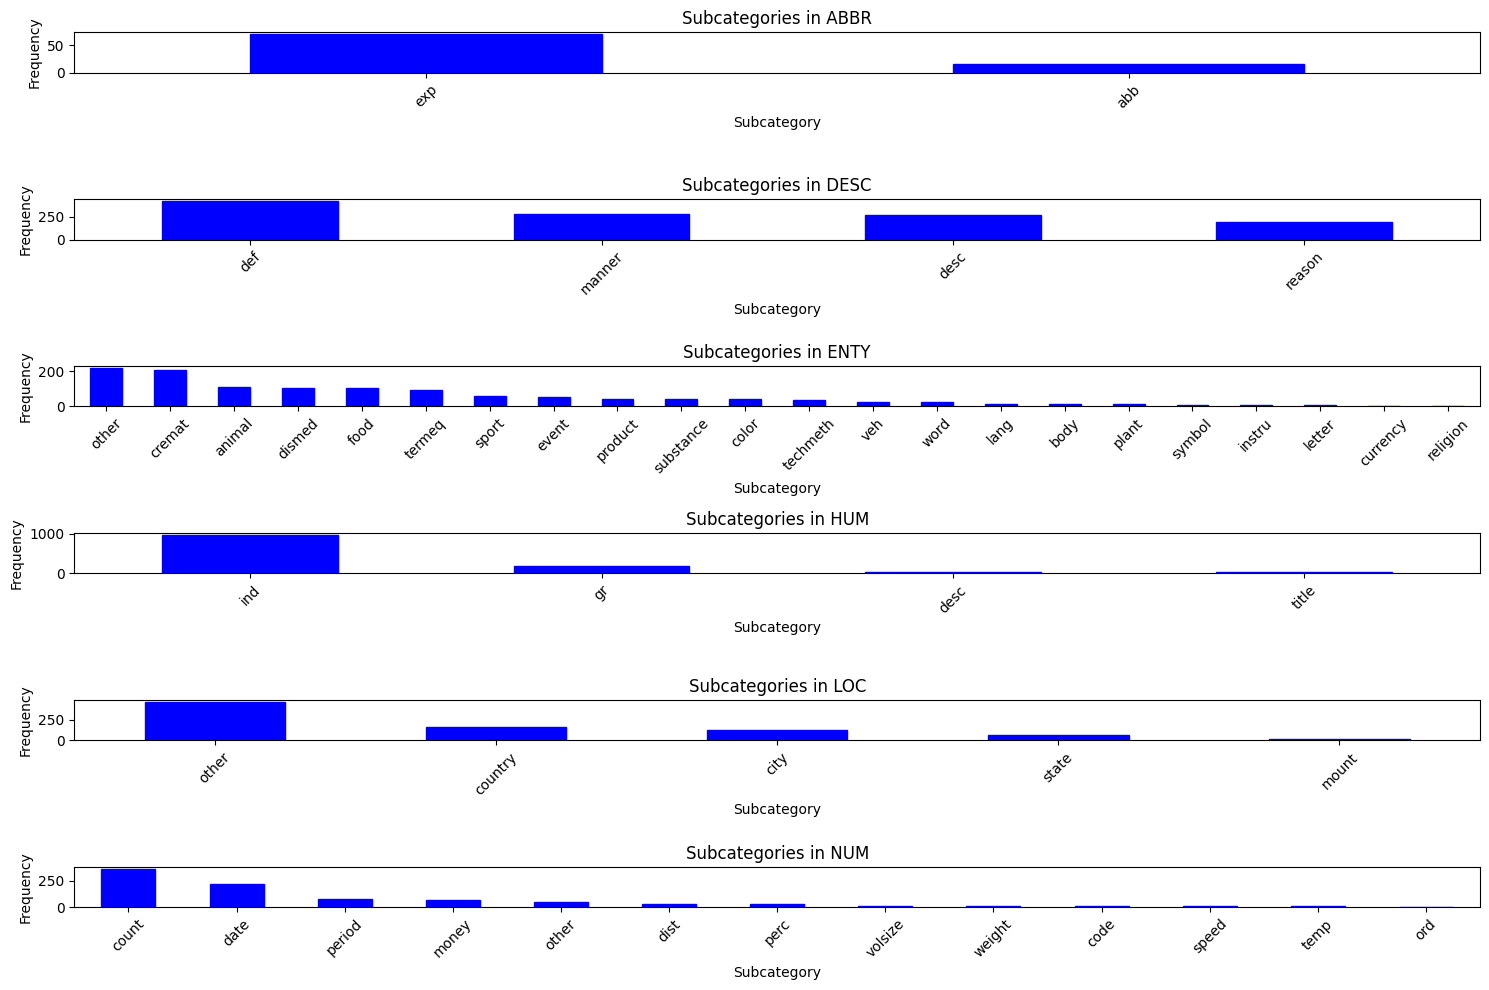

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Category and Subcategory, then count occurrences
subcategory_counts = df_train.groupby(['Category', 'Subcategory']).size().unstack(fill_value=0)

# Plot bar plots for each category
plt.figure(figsize=(15, 10))
categories = subcategory_counts.index

# Loop over each category and plot the subcategories
for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i + 1)
    subcategory_counts.loc[category].sort_values(ascending=False).loc[lambda x: x > 0].plot(kind='bar', color='blue', edgecolor='blue')
    plt.title(f'Subcategories in {category}')
    plt.xlabel('Subcategory')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


In [8]:
df_train['Question'] = df_train['Question'].str.lower()  # Convertir le texte en minuscules
df_train['Question'] = df_train['Question'].str.replace(r'[^\w\s]', '', regex=True)  # Supprimer les ponctuations
df_train['Question'] = df_train['Question'].str.strip()  # Supprimer les espaces inutiles


In [9]:
df_test['Question'] = df_test['Question'].str.lower()  # Convertir le texte en minuscules
df_test['Question'] = df_test['Question'].str.replace(r'[^\w\s]', '', regex=True)  # Supprimer les ponctuations
df_test['Question'] = df_test['Question'].str.strip()  # Supprimer les espaces inutiles

In [10]:
import spacy
from nltk.stem import PorterStemmer

# Load spaCy model for text processing
nlp = spacy.load("en_core_web_sm")
# Use the Porter stemming algorithm
stemmer = PorterStemmer()

specific_stop_words = {
    "a", "an", "the",
    "and", "or", "but", "so", "for", "nor", "yet",
    "about", "above", "across", "after", "against", "along", "among", "around", "at",
    "before", "behind", "below", "beneath", "beside", "between", "beyond", "by",
    "down", "during", "except", "for", "from", "in", "inside", "into", "like",
    "near", "of", "off", "on", "out", "outside", "over", "past", "since", "through",
    "to", "toward", "under", "until", "up", "upon", "with", "within", "without",
    "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself",
    "we", "us", "our", "ours", "ourselves",
    "I", "me", "my", "mine", "myself",
    "you", "your", "yours", "yourself", "yourselves","most"
}


def preprocess_text_keep_significant_words(text):
    doc = nlp(text)  # Analyze the text using spaCy
    stemmed_tokens = []
    
    for token in doc:
        # Check if the token is a specific stop word to remove
        if token.text.lower() in specific_stop_words:
            continue  # Skip this token entirely
        
        # Skip stop words, except for WH-questions
        if token.is_stop and token.tag_ not in ["WP", "WDT", "WP$", "WRB"]:
            lemmatized_token = token.lemma_
            stemmed_tokens.append(lemmatized_token)
        
        # WH-questions processing
        elif token.tag_ in ["WP", "WDT", "WP$", "WRB"]:
            lemmatized_token = token.lemma_
            stemmed_tokens.append(lemmatized_token)
        
        # Processing other words
        else:
            lemmatized_token = token.lemma_
            stemmed_tokens.append(lemmatized_token)
    
    return ' '.join(stemmed_tokens)  # Return the preprocessed sentence as a string



In [11]:
X_train = df_train["Question"]
X_test = df_test["Question"]

# Step 1: Classify into Category
y_train_category = df_train["Category"]
y_test_category = df_test["Category"]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2),max_features=1000,min_df=5,max_df=0.9,smooth_idf=True,sublinear_tf=True)


# SVM for cat_subCat

In [13]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
# Combine Category and Subcategory into a single label
df_train["Combined_Label"] = df_train["Category"] + "_" + df_train["Subcategory"]
df_test["Combined_Label"] = df_test["Category"] + "_" + df_test["Subcategory"]

# Text preprocessing and feature extraction
X_train = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))
# Combined label as target
y_train_combined = df_train["Combined_Label"]
y_test_combined = df_test["Combined_Label"]

# Train SVM for combined labels
clf_combined = SVC(kernel="linear", random_state=42)
clf_combined.fit(X_train, y_train_combined)

# Predict combined labels for the test set
y_pred_combined = clf_combined.predict(X_test)

# Add predictions to test dataframe
df_test["Predicted_Combined_Label"] = y_pred_combined

# Split combined predictions back into Category and Subcategory
df_test["Predicted_Category"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[0])
df_test["Predicted_Subcategory"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[1])

# Evaluation
print("Final Classification Results:")
print(df_test[["Question", "Category", "Subcategory", "Predicted_Category", "Predicted_Subcategory"]])




Final Classification Results:
                                  Question Category Subcategory  \
0       how far is it from denver to aspen      NUM        dist   
1    what county is modesto  california in      LOC        city   
2                          who was galileo      HUM        desc   
3                          what is an atom     DESC         def   
4           when did hawaii become a state      NUM        date   
..                                     ...      ...         ...   
495   who was the 22nd president of the us      HUM         ind   
496   what is the money they use in zambia     ENTY    currency   
497                how many feet in a mile      NUM       count   
498      what is the birthstone of october     ENTY   substance   
499                          what is ecoli     DESC         def   

    Predicted_Category Predicted_Subcategory  
0                  NUM                  dist  
1                  LOC                 other  
2                  HUM  

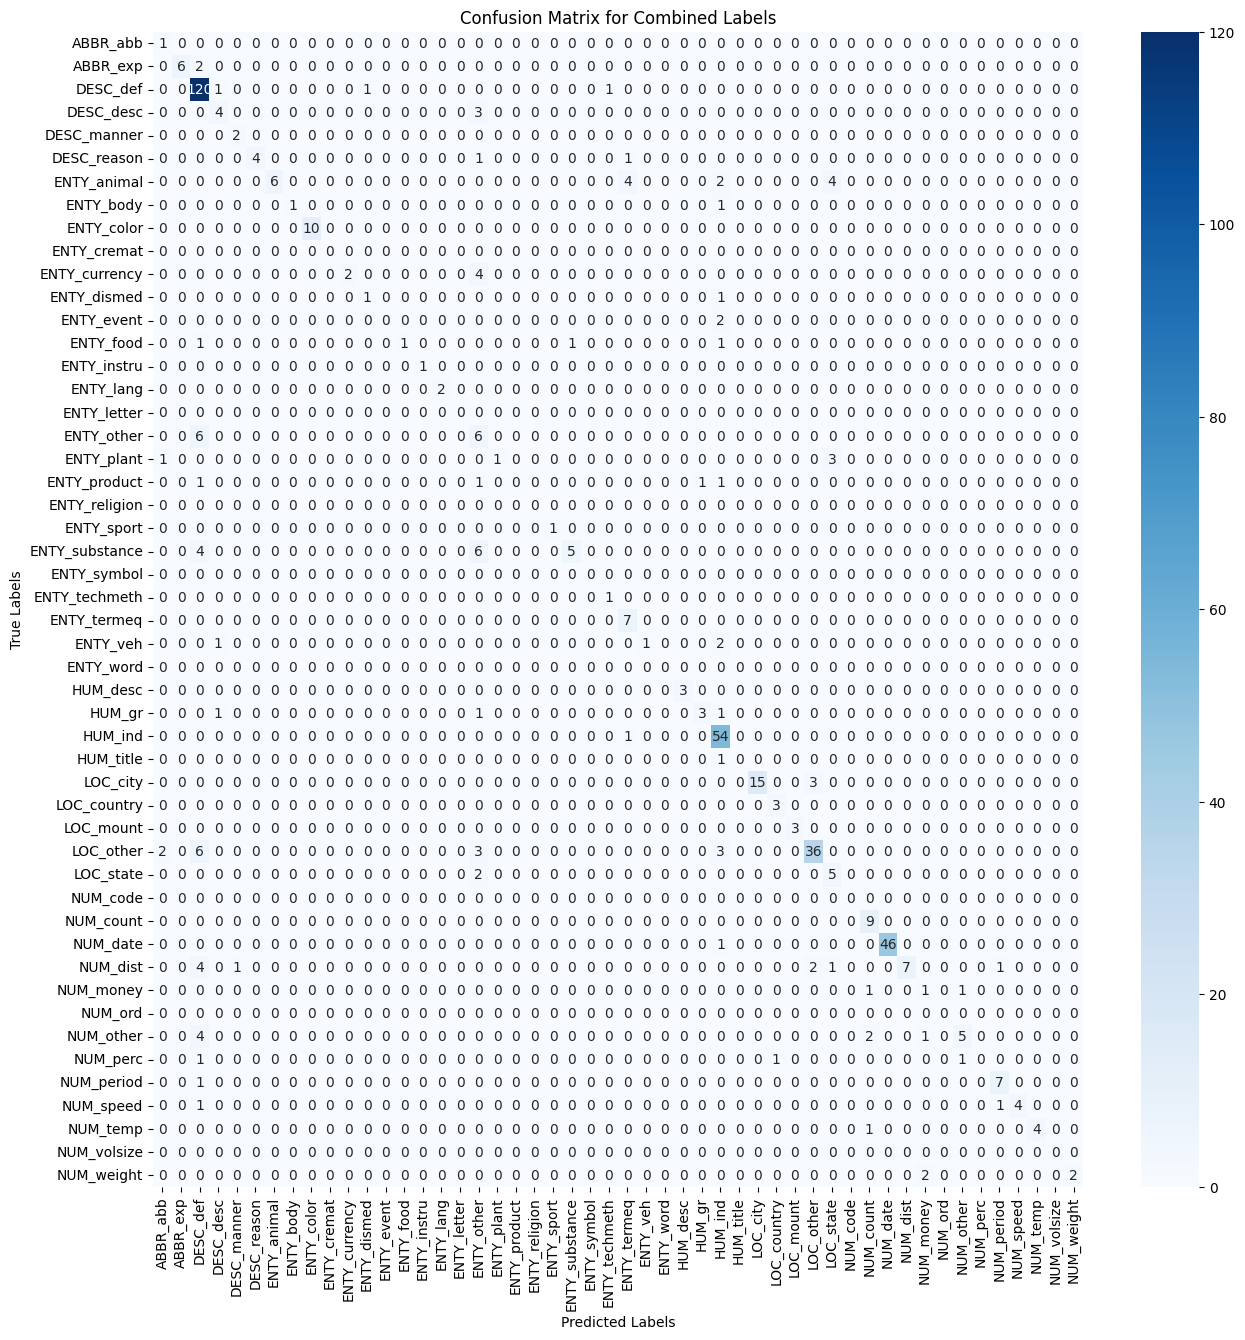

Classification Report for Combined Labels:
                precision    recall  f1-score   support

      ABBR_abb       0.25      1.00      0.40         1
      ABBR_exp       1.00      0.75      0.86         8
      DESC_def       0.79      0.98      0.88       123
     DESC_desc       0.57      0.57      0.57         7
   DESC_manner       0.67      1.00      0.80         2
   DESC_reason       1.00      0.67      0.80         6
   ENTY_animal       1.00      0.38      0.55        16
     ENTY_body       1.00      0.50      0.67         2
    ENTY_color       1.00      1.00      1.00        10
 ENTY_currency       1.00      0.33      0.50         6
   ENTY_dismed       0.50      0.50      0.50         2
    ENTY_event       0.00      0.00      0.00         2
     ENTY_food       1.00      0.25      0.40         4
   ENTY_instru       1.00      1.00      1.00         1
     ENTY_lang       1.00      1.00      1.00         2
    ENTY_other       0.22      0.50      0.31        12
    

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [138]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Confusion Matrix
conf_matrix = confusion_matrix(y_test_combined, y_pred_combined, labels=clf_combined.classes_)

# Plot the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf_combined.classes_, yticklabels=clf_combined.classes_)
plt.title("Confusion Matrix for Combined Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report for Combined Labels:")
print(classification_report(y_test_combined, y_pred_combined))

In [91]:
import seaborn as sns
# Classification report for combined labels (precision, recall, F1-score, support)
print("\nCombined Label Classification Report:")
print(classification_report(y_test_combined, y_pred_combined))



Combined Label Classification Report:
                precision    recall  f1-score   support

      ABBR_abb       0.25      1.00      0.40         1
      ABBR_exp       1.00      0.75      0.86         8
      DESC_def       0.79      0.98      0.88       123
     DESC_desc       0.57      0.57      0.57         7
   DESC_manner       0.67      1.00      0.80         2
   DESC_reason       1.00      0.67      0.80         6
   ENTY_animal       1.00      0.38      0.55        16
     ENTY_body       1.00      0.50      0.67         2
    ENTY_color       1.00      1.00      1.00        10
 ENTY_currency       1.00      0.33      0.50         6
   ENTY_dismed       0.50      0.50      0.50         2
    ENTY_event       0.00      0.00      0.00         2
     ENTY_food       1.00      0.25      0.40         4
   ENTY_instru       1.00      1.00      1.00         1
     ENTY_lang       1.00      1.00      1.00         2
    ENTY_other       0.22      0.50      0.31        12
    ENTY

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [60]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report
report = classification_report(y_test_combined, y_pred_combined, output_dict=True)

# Convert the report into a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Extract F1-scores for all classes and averages (macro, weighted, accuracy)
f1_scores = report_df[['f1-score']]

# Display F1-scores for each class and the overall model performance
print("\nF1-scores for All Classes and Model Performance:")
print(f1_scores)



F1-scores for All Classes and Model Performance:
                f1-score
ABBR_abb        0.400000
ABBR_exp        0.857143
DESC_def        0.885609
DESC_desc       0.615385
DESC_manner     0.800000
DESC_reason     0.800000
ENTY_animal     0.545455
ENTY_body       0.666667
ENTY_color      1.000000
ENTY_currency   0.500000
ENTY_dismed     0.500000
ENTY_event      0.000000
ENTY_food       0.400000
ENTY_instru     1.000000
ENTY_lang       1.000000
ENTY_other      0.292683
ENTY_plant      0.333333
ENTY_product    0.000000
ENTY_sport      1.000000
ENTY_substance  0.476190
ENTY_techmeth   0.666667
ENTY_termeq     0.700000
ENTY_veh        0.400000
HUM_desc        1.000000
HUM_gr          0.600000
HUM_ind         0.864000
HUM_title       0.000000
LOC_city        0.909091
LOC_country     0.857143
LOC_mount       1.000000
LOC_other       0.817204
LOC_state       0.500000
NUM_count       0.818182
NUM_date        0.989247
NUM_dist        0.608696
NUM_money       0.285714
NUM_other       0.526316


c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [61]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test_combined, y_pred_combined, output_dict=True)

# Extract the overall F1-score (macro average or weighted average)
f1_score_model = report['macro avg']['f1-score']  # or use 'weighted avg'

# Print the overall F1-score for the model
print(f"\nOverall F1-Score for the Model (Macro Avg): {f1_score_model}")



Overall F1-Score for the Model (Macro Avg): 0.6379478294228083


c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [62]:
# Example of new questions (updated)
new_questions = [
    "who is the best player in the world?",
    "where is the best water in the world ?"
]

# Preprocess and transform new questions
X_new = tfidf_vectorizer.transform([preprocess_text_keep_significant_words(q) for q in new_questions])

# Predict combined labels for new questions
y_pred_combined_new = clf_combined.predict(X_new)

# Split combined predictions back into Category and Subcategory
predicted_combined_labels = [label.split("_") for label in y_pred_combined_new]
predicted_categories = [label[0] for label in predicted_combined_labels]
predicted_subcategories = [label[1] for label in predicted_combined_labels]

# Display predictions for new questions
for i, question in enumerate(new_questions):
    print(f"Question: {question}")
    print(f"Predicted Category: {predicted_categories[i]}")
    print(f"Predicted Subcategory: {predicted_subcategories[i]}")
    print()


Question: who is the best player in the world?
Predicted Category: HUM
Predicted Subcategory: ind

Question: where is the best water in the world ?
Predicted Category: LOC
Predicted Subcategory: other



# SVM for Cat and then SubCat

In [118]:
# Step 1: Train SVM for Category classification
X_train_category = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test_category = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Category as target
y_train_category = df_train["Category"]
y_test_category = df_test["Category"]

# Train SVM for category classification
clf_category = SVC(kernel="linear", random_state=42)
clf_category.fit(X_train_category, y_train_category)

# Predict categories for the test set
y_pred_category = clf_category.predict(X_test_category)

# Add predicted Category to the test set for hierarchical classification
df_test["Predicted_Category"] = y_pred_category

# Step 2: Train a subcategory classifier for each category
subcategory_classifiers = {}

# Train separate classifiers for each category
for category in df_train["Category"].unique():
    # Filter data for the current category
    category_train_data = df_train[df_train["Category"] == category]
    X_train_sub = tfidf_vectorizer.transform(category_train_data["Question"].apply(preprocess_text_keep_significant_words))
    y_train_sub = category_train_data["Subcategory"]
    
    # Train an SVM classifier for this category
    clf_subcategory = SVC(kernel="linear", random_state=42)
    clf_subcategory.fit(X_train_sub, y_train_sub)
    
    # Save the classifier for later use
    subcategory_classifiers[category] = clf_subcategory

# Step 3: Predict Subcategories based on the predicted Category
def predict_subcategory(row):
    category = row["Predicted_Category"]
    question = row["Question"]
    clf_sub = subcategory_classifiers[category]
    return clf_sub.predict(tfidf_vectorizer.transform([question]))[0]

# Predict Subcategory for each test sample
df_test["Predicted_Subcategory"] = df_test.apply(predict_subcategory, axis=1)


# Classification report for Category
print("Category Classification Report:")
print(classification_report(y_test_category, y_pred_category))

# Classification report for Subcategory
y_test_subcategory = df_test["Subcategory"]
y_pred_subcategory = df_test["Predicted_Subcategory"]
print("Subcategory Classification Report:")
print(classification_report(y_test_subcategory, y_pred_subcategory))

Category Classification Report:
              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.86      0.95      0.90       138
        ENTY       0.73      0.74      0.74        94
         HUM       0.84      0.94      0.88        65
         LOC       0.90      0.79      0.84        81
         NUM       1.00      0.87      0.93       113

    accuracy                           0.86       500
   macro avg       0.85      0.84      0.85       500
weighted avg       0.87      0.86      0.86       500

Subcategory Classification Report:
              precision    recall  f1-score   support

         abb       0.33      1.00      0.50         1
      animal       0.64      0.56      0.60        16
        body       0.50      0.50      0.50         2
        city       1.00      0.78      0.88        18
       color       1.00      0.80      0.89        10
       count       0.60      1.00      0.75         9
     countr

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [120]:
# Step 1: Train SVM for Category classification
X_train_category = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test_category = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Category as target
y_train_category = df_train["Category"]
y_test_category = df_test["Category"]

# Train SVM for category classification
clf_category = SVC(kernel="linear", random_state=42)
clf_category.fit(X_train_category, y_train_category)

# Predict categories for the test set
y_pred_category = clf_category.predict(X_test_category)

# Add predicted Category to the test set for hierarchical classification
df_test["Predicted_Category"] = y_pred_category

# Step 2: Train a subcategory classifier for each category
subcategory_classifiers = {}

# Train separate classifiers for each category
for category in df_train["Category"].unique():
    # Filter data for the current category
    category_train_data = df_train[df_train["Category"] == category]
    X_train_sub = tfidf_vectorizer.transform(category_train_data["Question"].apply(preprocess_text_keep_significant_words))
    y_train_sub = category_train_data["Subcategory"]
    
    # Train an SVM classifier for this category
    clf_subcategory = SVC(kernel="linear", random_state=42)
    clf_subcategory.fit(X_train_sub, y_train_sub)
    
    # Save the classifier for later use
    subcategory_classifiers[category] = clf_subcategory

# Step 3: Predict Subcategories based on the predicted Category
def predict_subcategory(row):
    category = row["Predicted_Category"]
    question = row["Question"]
    clf_sub = subcategory_classifiers[category]
    return clf_sub.predict(tfidf_vectorizer.transform([question]))[0]

# Predict Subcategory for each test sample
df_test["Predicted_Subcategory"] = df_test.apply(predict_subcategory, axis=1)

# Step 4: Generate combined classification report
from sklearn.metrics import classification_report

# Combine both category and subcategory into a single report
print("Combined Classification Report:")

# Prepare the true and predicted labels as a tuple (Category, Subcategory)
y_test_combined = list(zip(df_test["Category"], df_test["Subcategory"]))
y_pred_combined = list(zip(df_test["Predicted_Category"], df_test["Predicted_Subcategory"]))

# Create labels for display
unique_categories = df_test["Category"].unique()
unique_subcategories = df_test["Subcategory"].unique()

# Generate a custom label for each category-subcategory pair
labels = [(cat, sub) for cat in unique_categories for sub in unique_subcategories if sub in df_test[df_test["Category"] == cat]["Subcategory"].unique()]

# Flatten the tuple into a single string label for classification report
y_test_combined_flat = ["|".join(map(str, item)) for item in y_test_combined]
y_pred_combined_flat = ["|".join(map(str, item)) for item in y_pred_combined]
labels_flat = ["|".join(map(str, item)) for item in labels]

# Generate classification report
report = classification_report(y_test_combined_flat, y_pred_combined_flat, labels=labels_flat, zero_division=0)

print(report)


Combined Classification Report:
                precision    recall  f1-score   support

      NUM|dist       1.00      0.44      0.61        16
      NUM|date       1.00      0.98      0.99        47
    NUM|weight       1.00      0.50      0.67         4
     NUM|other       0.71      0.42      0.53        12
     NUM|speed       1.00      0.83      0.91         6
      NUM|temp       1.00      0.60      0.75         5
    NUM|period       0.78      0.88      0.82         8
     NUM|count       0.60      1.00      0.75         9
     NUM|money       0.00      0.00      0.00         3
      NUM|perc       1.00      0.67      0.80         3
      LOC|city       1.00      0.78      0.88        18
     LOC|other       0.88      0.76      0.82        50
     LOC|mount       1.00      0.67      0.80         3
     LOC|state       0.56      0.71      0.62         7
   LOC|country       1.00      1.00      1.00         3
      HUM|desc       0.00      0.00      0.00         3
        HUM|gr 

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Combine Category and Subcategory into a single label
df_train["Combined_Label"] = df_train["Category"] + "_" + df_train["Subcategory"]
df_test["Combined_Label"] = df_test["Category"] + "_" + df_test["Subcategory"]

# Text preprocessing and feature extraction
X_train = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Combined label as target
y_train_combined = df_train["Combined_Label"]
y_test_combined = df_test["Combined_Label"]

# Train Random Forest for combined labels
clf_combined = RandomForestClassifier(random_state=42)
clf_combined.fit(X_train, y_train_combined)

# Predict combined labels for the test set
y_pred_combined = clf_combined.predict(X_test)

# Add predictions to test dataframe
df_test["Predicted_Combined_Label"] = y_pred_combined

# Split combined predictions back into Category and Subcategory
df_test["Predicted_Category"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[0])
df_test["Predicted_Subcategory"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[1])

# Evaluation
print("Final Classification Results:")
print(df_test[["Question", "Category", "Subcategory", "Predicted_Category", "Predicted_Subcategory"]])

# Classification report
print("Combined Label Classification Report:")
print(classification_report(y_test_combined, y_pred_combined))


Final Classification Results:
                                  Question Category Subcategory  \
0       how far is it from denver to aspen      NUM        dist   
1    what county is modesto  california in      LOC        city   
2                          who was galileo      HUM        desc   
3                          what is an atom     DESC         def   
4           when did hawaii become a state      NUM        date   
..                                     ...      ...         ...   
495   who was the 22nd president of the us      HUM         ind   
496   what is the money they use in zambia     ENTY    currency   
497                how many feet in a mile      NUM       count   
498      what is the birthstone of october     ENTY   substance   
499                          what is ecoli     DESC         def   

    Predicted_Category Predicted_Subcategory  
0                  NUM                  dist  
1                  LOC                 other  
2                  HUM  

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Combine Category and Subcategory into a single label
df_train["Combined_Label"] = df_train["Category"] + "_" + df_train["Subcategory"]
df_test["Combined_Label"] = df_test["Category"] + "_" + df_test["Subcategory"]

# Text preprocessing and feature extraction
X_train = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Combined label as target
y_train_combined = df_train["Combined_Label"]
y_test_combined = df_test["Combined_Label"]

# Train Logistic Regression for combined labels
clf_combined = LogisticRegression(random_state=42, max_iter=1000)
clf_combined.fit(X_train, y_train_combined)

# Predict combined labels for the test set
y_pred_combined = clf_combined.predict(X_test)

# Add predictions to test dataframe
df_test["Predicted_Combined_Label"] = y_pred_combined

# Split combined predictions back into Category and Subcategory
df_test["Predicted_Category"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[0])
df_test["Predicted_Subcategory"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[1])

# Classification report
print("Combined Label Classification Report:")
print(classification_report(y_test_combined, y_pred_combined))


Combined Label Classification Report:
                precision    recall  f1-score   support

      ABBR_abb       1.00      1.00      1.00         1
      ABBR_exp       1.00      0.75      0.86         8
      DESC_def       0.77      0.98      0.86       123
     DESC_desc       0.75      0.43      0.55         7
   DESC_manner       0.67      1.00      0.80         2
   DESC_reason       1.00      0.83      0.91         6
   ENTY_animal       1.00      0.38      0.55        16
     ENTY_body       0.00      0.00      0.00         2
    ENTY_color       1.00      0.90      0.95        10
 ENTY_currency       0.00      0.00      0.00         6
   ENTY_dismed       0.50      0.50      0.50         2
    ENTY_event       0.00      0.00      0.00         2
     ENTY_food       1.00      0.25      0.40         4
   ENTY_instru       1.00      1.00      1.00         1
     ENTY_lang       1.00      1.00      1.00         2
    ENTY_other       0.21      0.42      0.28        12
    ENTY_

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [107]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Combine Category and Subcategory into a single label
df_train["Combined_Label"] = df_train["Category"] + "_" + df_train["Subcategory"]
df_test["Combined_Label"] = df_test["Category"] + "_" + df_test["Subcategory"]

# Text preprocessing and feature extraction
X_train = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Combined label as target
y_train_combined = df_train["Combined_Label"]
y_test_combined = df_test["Combined_Label"]

# Train Gradient Boosting for combined labels
clf_combined = GradientBoostingClassifier(random_state=42)
clf_combined.fit(X_train, y_train_combined)

# Predict combined labels for the test set
y_pred_combined = clf_combined.predict(X_test)

# Add predictions to test dataframe
df_test["Predicted_Combined_Label"] = y_pred_combined

# Split combined predictions back into Category and Subcategory
df_test["Predicted_Category"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[0])
df_test["Predicted_Subcategory"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[1])


# Classification report
print("Combined Label Classification Report:")
print(classification_report(y_test_combined, y_pred_combined))


Combined Label Classification Report:
                precision    recall  f1-score   support

      ABBR_abb       0.33      1.00      0.50         1
      ABBR_exp       1.00      0.75      0.86         8
      DESC_def       0.81      0.96      0.88       123
     DESC_desc       0.33      0.43      0.38         7
   DESC_manner       1.00      0.50      0.67         2
   DESC_reason       1.00      0.83      0.91         6
   ENTY_animal       0.67      0.50      0.57        16
     ENTY_body       0.00      0.00      0.00         2
    ENTY_color       1.00      1.00      1.00        10
 ENTY_currency       0.00      0.00      0.00         6
   ENTY_dismed       0.50      0.50      0.50         2
    ENTY_event       0.33      0.50      0.40         2
     ENTY_food       0.50      0.25      0.33         4
   ENTY_instru       1.00      1.00      1.00         1
     ENTY_lang       1.00      0.50      0.67         2
    ENTY_other       0.43      0.25      0.32        12
    ENTY_

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

# Combination

# cat_subcat


In [108]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Combine Category and Subcategory into a single label
df_train["Combined_Label"] = df_train["Category"] + "_" + df_train["Subcategory"]
df_test["Combined_Label"] = df_test["Category"] + "_" + df_test["Subcategory"]

# Text preprocessing and feature extraction
X_train = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Combined label as target
y_train_combined = df_train["Combined_Label"]
y_test_combined = df_test["Combined_Label"]

# Define base models
svc = SVC(kernel="linear", probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
nb = MultinomialNB()
knn = KNeighborsClassifier(n_neighbors=5)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a VotingClassifier with soft voting (use 'hard' for majority class voting)
ensemble_model = VotingClassifier(
    estimators=[
        ('svc', svc),
        ('rf', rf),
        ('lr', lr),
        ('nb', nb),
        ('knn', knn),
        ('gb', gb)
    ],
    voting='hard'  # Use 'hard' for majority class voting
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train_combined)

# Predict combined labels for the test set
y_pred_combined = ensemble_model.predict(X_test)

# Add predictions to the test dataframe
df_test["Predicted_Combined_Label"] = y_pred_combined

# Split combined predictions back into Category and Subcategory
df_test["Predicted_Category"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[0])
df_test["Predicted_Subcategory"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[1])



# Classification report
print(classification_report(y_test_combined, y_pred_combined))


                precision    recall  f1-score   support

      ABBR_abb       0.33      1.00      0.50         1
      ABBR_exp       1.00      0.75      0.86         8
      DESC_def       0.72      0.99      0.84       123
     DESC_desc       0.86      0.86      0.86         7
   DESC_manner       0.67      1.00      0.80         2
   DESC_reason       1.00      0.83      0.91         6
   ENTY_animal       1.00      0.38      0.55        16
     ENTY_body       0.00      0.00      0.00         2
    ENTY_color       1.00      1.00      1.00        10
 ENTY_currency       1.00      0.33      0.50         6
   ENTY_dismed       0.50      0.50      0.50         2
    ENTY_event       0.00      0.00      0.00         2
     ENTY_food       1.00      0.25      0.40         4
   ENTY_instru       1.00      1.00      1.00         1
     ENTY_lang       1.00      0.50      0.67         2
    ENTY_other       0.33      0.42      0.37        12
    ENTY_plant       1.00      0.20      0.33  

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [140]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

# Step 1: Preprocessing and Feature Extraction
tfidf_vectorizer = TfidfVectorizer()

X_train_category = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test_category = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Define targets for Category and Subcategory
y_train_category = df_train["Category"]
y_test_category = df_test["Category"]

# Step 2: Train Ensemble Classifier for Category Classification
svc = SVC(kernel="linear", probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
nb = MultinomialNB()
knn = KNeighborsClassifier(n_neighbors=5)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Ensemble model for Category
ensemble_category = VotingClassifier(
    estimators=[
        ('svc', svc),
        ('rf', rf),
        ('lr', lr),
        ('nb', nb),
        ('knn', knn),
        ('gb', gb)
    ],
    voting='hard'  # Majority voting
)

ensemble_category.fit(X_train_category, y_train_category)

# Predict Categories
y_pred_category = ensemble_category.predict(X_test_category)
df_test["Predicted_Category"] = y_pred_category

# Step 3: Train Subcategory Classifiers for Each Category
subcategory_classifiers = {}

for category in df_train["Category"].unique():
    # Filter data for the current category
    category_train_data = df_train[df_train["Category"] == category]
    X_train_sub = tfidf_vectorizer.transform(category_train_data["Question"].apply(preprocess_text_keep_significant_words))
    y_train_sub = category_train_data["Subcategory"]
    
    # Use an ensemble model for subcategory classification
    ensemble_sub = VotingClassifier(
        estimators=[
            ('svc', svc),
            ('rf', rf),
            ('lr', lr),
            ('nb', nb),
            ('knn', knn),
            ('gb', gb)
        ],
        voting='hard'
    )
    ensemble_sub.fit(X_train_sub, y_train_sub)
    subcategory_classifiers[category] = ensemble_sub

# Step 4: Predict Subcategories Based on Predicted Categories
def predict_subcategory(row):
    category = row["Predicted_Category"]
    question = row["Question"]
    clf_sub = subcategory_classifiers[category]
    return clf_sub.predict(tfidf_vectorizer.transform([question]))[0]

df_test["Predicted_Subcategory"] = df_test.apply(predict_subcategory, axis=1)

# Step 5: Generate Classification Reports

# Combined Report for Category and Subcategory
print("Combined Classification Report:")
y_test_combined = list(zip(df_test["Category"], df_test["Subcategory"]))
y_pred_combined = list(zip(df_test["Predicted_Category"], df_test["Predicted_Subcategory"]))

# Create labels for combined classification
unique_categories = df_test["Category"].unique()
unique_subcategories = df_test["Subcategory"].unique()
labels = [(cat, sub) for cat in unique_categories for sub in unique_subcategories if sub in df_test[df_test["Category"] == cat]["Subcategory"].unique()]

# Flatten labels for classification report
y_test_combined_flat = ["|".join(map(str, item)) for item in y_test_combined]
y_pred_combined_flat = ["|".join(map(str, item)) for item in y_pred_combined]
labels_flat = ["|".join(map(str, item)) for item in labels]

# Generate classification report
report = classification_report(y_test_combined_flat, y_pred_combined_flat, labels=labels_flat, zero_division=0)
print(report)


Combined Classification Report:
                precision    recall  f1-score   support

      NUM|dist       1.00      0.44      0.61        16
      NUM|date       0.94      0.94      0.94        47
    NUM|weight       1.00      0.50      0.67         4
     NUM|other       0.83      0.42      0.56        12
     NUM|speed       1.00      0.50      0.67         6
      NUM|temp       1.00      0.80      0.89         5
    NUM|period       0.64      0.88      0.74         8
     NUM|count       0.64      1.00      0.78         9
     NUM|money       0.50      0.33      0.40         3
      NUM|perc       1.00      0.33      0.50         3
      LOC|city       0.93      0.78      0.85        18
     LOC|other       0.86      0.76      0.81        50
     LOC|mount       1.00      0.67      0.80         3
     LOC|state       0.40      0.57      0.47         7
   LOC|country       1.00      1.00      1.00         3
      HUM|desc       0.00      0.00      0.00         3
        HUM|gr 

# ANN

# cat_subcat

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Combine Category and Subcategory into a single label
df_train["Combined_Label"] = df_train["Category"] + "_" + df_train["Subcategory"]
df_test["Combined_Label"] = df_test["Category"] + "_" + df_test["Subcategory"]

# Text preprocessing and feature extraction
X_train = tfidf_vectorizer.fit_transform(df_train["Question"].apply(preprocess_text_keep_significant_words))
X_test = tfidf_vectorizer.transform(df_test["Question"].apply(preprocess_text_keep_significant_words))

# Combined label as target
y_train_combined = df_train["Combined_Label"]
y_test_combined = df_test["Combined_Label"]

# Encode the labels (combined label) to integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_combined_encoded = label_encoder.fit_transform(y_train_combined)
y_test_combined_encoded = label_encoder.transform(y_test_combined)

# ANN Model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(256, activation='relu'))  # Hidden layer
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with softmax

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_combined_encoded, epochs=15, batch_size=64, validation_data=(X_test, y_test_combined_encoded))

# Predict combined labels for the test set
y_pred_combined_encoded = model.predict(X_test)
y_pred_combined = label_encoder.inverse_transform(y_pred_combined_encoded.argmax(axis=1))

# Add predictions to test dataframe
df_test["Predicted_Combined_Label"] = y_pred_combined

# Split combined predictions back into Category and Subcategory
df_test["Predicted_Category"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[0])
df_test["Predicted_Subcategory"] = df_test["Predicted_Combined_Label"].apply(lambda x: x.split("_")[1])


# Classification report
print("Combined Label Classification Report:")
print(classification_report(y_test_combined, y_pred_combined))


Epoch 1/15


c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2140 - loss: 3.3684 - val_accuracy: 0.5460 - val_loss: 2.0375
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5946 - loss: 1.7590 - val_accuracy: 0.6820 - val_loss: 1.4582
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7459 - loss: 1.1008 - val_accuracy: 0.7360 - val_loss: 1.2107
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8103 - loss: 0.8056 - val_accuracy: 0.7620 - val_loss: 1.1154
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8565 - loss: 0.6288 - val_accuracy: 0.7720 - val_loss: 0.9989
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8821 - loss: 0.5076 - val_accuracy: 0.7660 - val_loss: 0.9742
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8874 - loss: 0.4525 - val_accuracy: 0.7760 - val_loss: 0.9973
Epoch 8/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9076 - loss: 0.3774 - val_accuracy: 0.7720 - val_loss: 0.9480
Epo

c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alaed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [14]:
import joblib

# Save the trained VotingClassifier model to a file
joblib.dump(clf_combined, 'SVM_Cat_Subcat_model.pkl')

# Save the TF-IDF vectorizer to a file
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')



['tfidf_vectorizer.pkl']

In [21]:
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import joblib

# Load the saved VotingClassifier model and TF-IDF vectorizer
ensemble_model = joblib.load('SVM_Cat_Subcat_model.pkl')  # Load the ensemble model
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Load the TF-IDF vectorizer

# Create the main window
window = tk.Tk()
window.title("Class Classification")
window.geometry("500x400")
window.resizable(False, False)

# Set a theme for a modern look
style = ttk.Style(window)
style.theme_use('clam')

# Customize the theme
style.configure(
    "TLabel",
    background="#f8f9fa",
    foreground="#333",
    font=("Arial", 10)
)
style.configure(
    "TButton",
    background="#007bff",
    foreground="#fff",
    font=("Arial", 10, "bold"),
    padding=5
)
style.map(
    "TButton",
    background=[("active", "#0056b3")]
)
style.configure(
    "TEntry",
    padding=5
)

# Set the background color of the main window
window.configure(bg="#f8f9fa")

# Add a title label
title_label = ttk.Label(
    window,
    text="Class Classification Tool",
    font=("Arial", 16, "bold"),
    anchor="center"
)
title_label.pack(pady=20)

# Create a label for instructions
instruction_label = ttk.Label(
    window,
    text="Enter your question below and click 'Classify':",
    wraplength=400,
    anchor="center"
)
instruction_label.pack(pady=10)

# Create a text entry field for the question input
entry_frame = ttk.Frame(window)
entry_frame.pack(pady=10)
entry = ttk.Entry(entry_frame, width=50)
entry.grid(row=0, column=0, padx=5)
clear_button = ttk.Button(
    entry_frame,
    text="Clear",
    command=lambda: entry.delete(0, tk.END),
    style="TButton"
)
clear_button.grid(row=0, column=1, padx=5)

# Create a function to handle the button click
def classify_question():
    question = entry.get().strip()
    if not question:
        messagebox.showerror("Input Error", "Please enter a question.")
        return

    try:
        # Transform the input question using the loaded TF-IDF vectorizer
        question_tfidf = tfidf_vectorizer.transform([question])
        
        # Make prediction using the loaded ensemble model
        prediction = ensemble_model.predict(question_tfidf)[0]
        
        # Split the prediction back into category and subcategory
        predicted_category, predicted_subcategory = prediction.split("_")

        # Display the result in a message box
        messagebox.showinfo("Prediction Result", f"The predicted category is: {predicted_category}\nThe predicted subcategory is: {predicted_subcategory}")

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred during classification:\n{e}")

# Create a button to trigger classification
classify_button = ttk.Button(
    window,
    text="Classify",
    command=classify_question
)
classify_button.pack(pady=20)

# Add a footer for credit or help
footer_label = ttk.Label(
    window,
    text="Powered by NAILY BARKALLAH MALLOULI",
    font=("Arial", 8),
    anchor="center"
)

footer_label.pack(side="bottom", pady=10)

# Run the Tkinter event loop
window.mainloop()
